$\color{cyan}{\text{Data Collect and Cleaning}}$

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv("Dataset_Bangadesh.csv") #read dataset

In [3]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Atrai,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Gournadi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Alfadanga,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Fakirhat,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Banshkhali,2 BHK,NaN,1200,2.0,1.0,51.00


In [4]:
df["area_type"].value_counts()

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

In [5]:
df1=df.drop(['area_type','society','availability', 'balcony' ],axis='columns') #remove some unnessesary columns

In [6]:
df1.head()

,location,size,total_sqft,bath,price
0,Atrai,2 BHK,1056,2.0,39.07
1,Gournadi,4 Bedroom,2600,5.0,120.00
2,Alfadanga,3 BHK,1440,2.0,62.00
3,Fakirhat,3 BHK,1521,3.0,95.00
4,Banshkhali,2 BHK,1200,2.0,51.00


In [7]:
df1.isnull().sum() #Null value

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [8]:
df2=df1.dropna() #remove null value from dataset
df2.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [9]:
df2["size"].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [10]:
df2['bhk'] = df2['size'].apply(lambda x : int(x.split(' ')[0])) #split number of room from 'size' column

<ipython-input-10-740c19e60809>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['bhk'] = df2['size'].apply(lambda x : int(x.split(' ')[0])) #split number of room from 'size' column


In [11]:
df2.head()

,location,size,total_sqft,bath,price,bhk
0,Atrai,2 BHK,1056,2.0,39.07,2
1,Gournadi,4 Bedroom,2600,5.0,120.00,4
2,Alfadanga,3 BHK,1440,2.0,62.00,3
3,Fakirhat,3 BHK,1521,3.0,95.00,3
4,Banshkhali,2 BHK,1200,2.0,51.00,2


In [12]:
df2['bhk'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

In [13]:
df2[df2.bhk > 20] 

,location,size,total_sqft,bath,price,bhk
1718,Dupchanchia,27 BHK,8000,27.0,230.0,27
4684,Bagatipara,43 Bedroom,2400,40.0,660.0,43


In [14]:
df2.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [15]:
def is_false(x) :
    try :
        float(x)
    except :
        return False
    return True

In [16]:
df2[~df2['total_sqft'].apply(is_false)].head(10) #Show non-accurate value of 'total_sqft'

,location,size,total_sqft,bath,price,bhk
30,Akkelpur,4 BHK,2100 - 2850,4.0,186.000,4
122,Alikadam,4 BHK,3067 - 8156,4.0,477.000,4
137,8Th Phase Bancharampur,2 BHK,1042 - 1105,2.0,54.005,2
165,Bagher Para,2 BHK,1145 - 1340,2.0,43.490,2
188,Badalgachi,2 BHK,1015 - 1540,2.0,56.800,2
410,Balaganj,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Ashasuni,2 BHK,1195 - 1440,2.0,63.770,2
648,Chatmohar,9 Bedroom,4125Perch,9.0,265.000,9
661,Akkelpur,2 BHK,1120 - 1145,2.0,48.130,2
672,Srinivasa Nagar,4 Bedroom,3090 - 5002,4.0,445.000,4


In [17]:
def convert_sqft_to_num(x) :
    tokens = x.split('-')
    if len(tokens) == 2 :
        return (float(tokens[0]) + float(tokens[1]))/2
    try :
        return float(x)
    except :
        return None

In [18]:
df3 = df2.copy()
df3['total_sqft'] = df3['total_sqft'].apply(convert_sqft_to_num) #non-accurate to accurate
df3.head(3)

,location,size,total_sqft,bath,price,bhk
0,Atrai,2 BHK,1056.0,2.0,39.07,2
1,Gournadi,4 Bedroom,2600.0,5.0,120.00,4
2,Alfadanga,3 BHK,1440.0,2.0,62.00,3


In [19]:
df3.loc[30]

location      Akkelpur
size             4 BHK
total_sqft      2475.0
bath               4.0
price            186.0
bhk                  4
Name: 30, dtype: object

$\color{cyan}{\text{Feature Engineering}}$

In [20]:
df4 = df3
df4['price_per_sqft'] = df4['price']*100000/df4['total_sqft'] #create new column and count price per squarefeet
df4.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Atrai,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Gournadi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Alfadanga,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Fakirhat,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Banshkhali,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [21]:
len(df4.location.unique())

1294

In [22]:
df4.location = df4.location.apply(lambda x : x.strip())
location_state=df4["location"].value_counts()
location_state

Abhaynagar           539
Adarsha Sadar        396
Aditmari             302
Agailjhara           271
Ajmiriganj           237
                    ... 
Jagajyothi Layout      1
Pns Layout             1
Vinayakanagar          1
Lic Colony             1
Subramanya Nagar       1
Name: location, Length: 1284, dtype: int64

In [23]:
len(location_state[location_state <= 10])

1046

In [24]:
location_state_less_then_10 = location_state[location_state <= 10]
location_state_less_then_10

Sadashiva Nagar         10
Sector 1 Belabo         10
Nagappa Reddy Layout    10
Basapura                10
Khoksa                  10
                        ..
Jagajyothi Layout        1
Pns Layout               1
Vinayakanagar            1
Lic Colony               1
Subramanya Nagar         1
Name: location, Length: 1046, dtype: int64

In [25]:
len(df4.location.unique())

1284

In [26]:
#Rename location name(less then 10) to 'other'
df4.location = df4.location.apply(lambda x: 'other' if x in location_state_less_then_10 else x)
len(df4.location.unique())

239

In [27]:
df4.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,other,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Gournadi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Alfadanga,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Fakirhat,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Banshkhali,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Abhaynagar,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Chougachha,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Atwari,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Amtali,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


$\color{cyan}{\text{Outlier Removal}}$

In [28]:
df4[df4.total_sqft/df4.bhk < 300].head() #squarefoot per bhk(less then 300)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,Belabo,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Joypurhat Sadar,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,other,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [29]:
df4.shape

(13246, 7)

In [30]:
#Remove some location(bhk < 300)
df5 = df4[~(df4.total_sqft/df4.bhk < 300)]
df5.shape

(12502, 7)

In [31]:
df5.price_per_sqft.describe()

count     12456.000000
mean       6308.686199
std        4168.036014
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

In [32]:
#Remove very very high or very very low properties(price per sqft)
def rmv_pps_outlier(df) :
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location') :
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduce_df = subdf[(subdf.price_per_sqft > (m - st)) & (subdf.price_per_sqft <= (m+st))]
        df_out = pd.concat([df_out, reduce_df], ignore_index=True)
    return df_out
df6 = rmv_pps_outlier(df5)
df6.shape

(10706, 7)

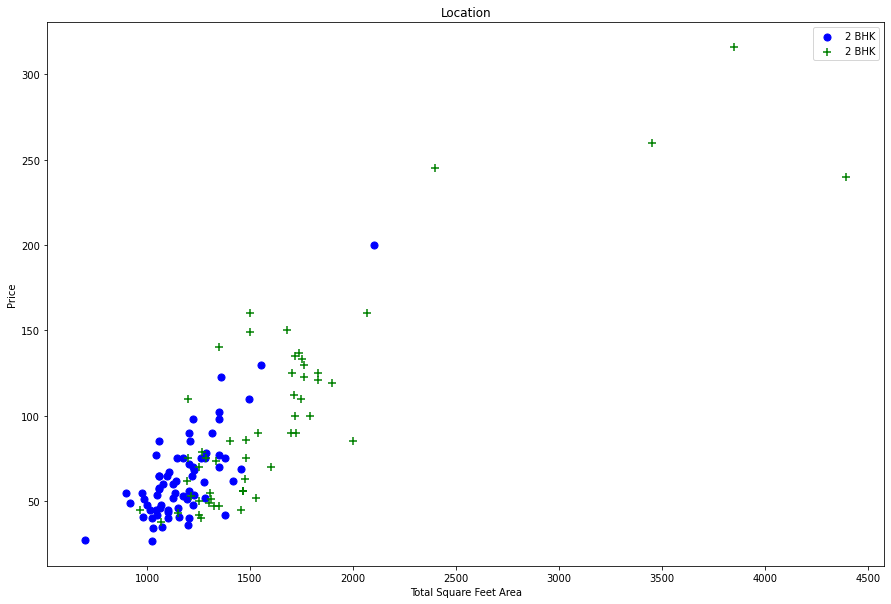

In [33]:
#Scatter Plot
def scatter(df, location) :
    bhk2 = df[(df.location == location) & (df.bhk == 2)]
    bhk3 = df[(df.location == location) & (df.bhk == 3)]
    matplotlib.rcParams['figure.figsize'] = (15, 10)
    plt.scatter(bhk2.total_sqft, bhk2.price, color = 'blue', label = '2 BHK', s = 50)
    plt.scatter(bhk3.total_sqft, bhk3.price, color = 'green', marker = '+', label = '2 BHK', s = 50)
    plt.xlabel('Total Square Feet Area')
    plt.ylabel('Price')
    plt.title("Location")
    plt.legend()
scatter(df6, 'Alikadam')

In [34]:
def rmv_bhk_outlier(df) :
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location') :
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk') :
            bhk_stats[bhk] = {
                'mean' : np.mean(bhk_df.price_per_sqft),
                'std' : np.std(bhk_df.price_per_sqft),
                'count' : bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk') :
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count'] > 5 :
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft < (stats['mean'])].index.values)
    return df.drop(exclude_indices, axis = 'index')

In [35]:
df7 = rmv_bhk_outlier(df6)
df7.shape

(7375, 7)

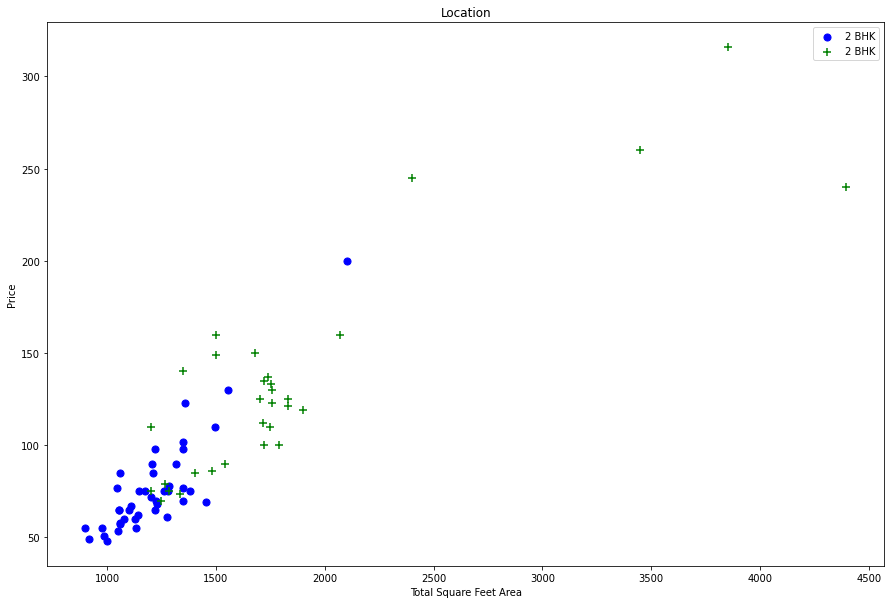

In [36]:
scatter(df7, 'Alikadam')

Text(0, 0.5, 'Count')

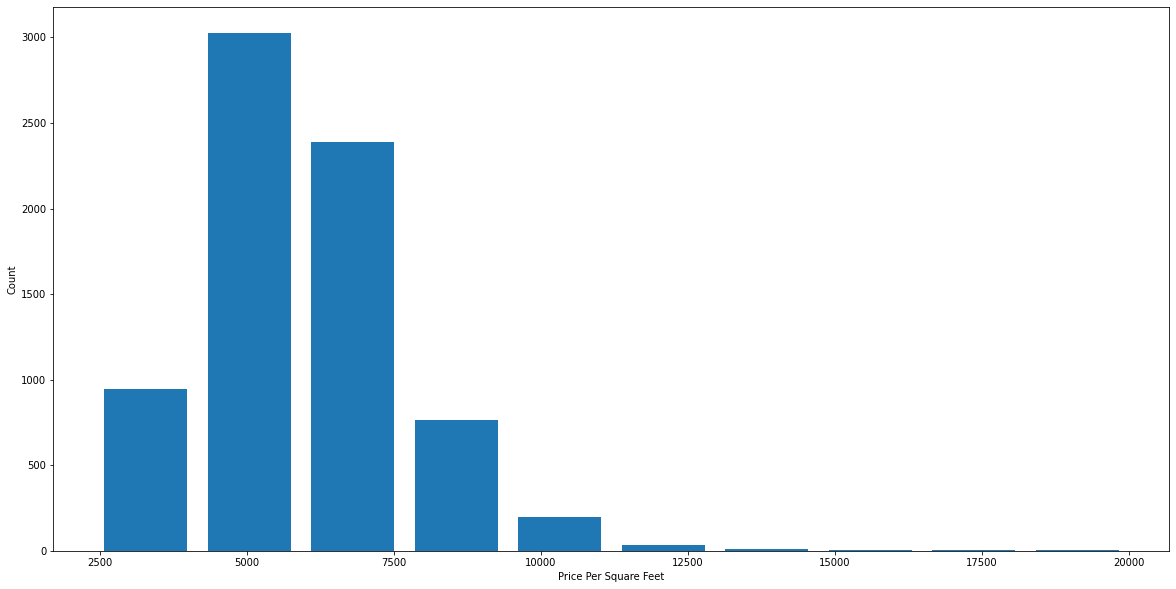

In [37]:
matplotlib.rcParams['figure.figsize'] = (20, 10)
plt.hist(df7.price_per_sqft, rwidth = 0.8)
plt.xlabel('Price Per Square Feet')
plt.ylabel('Count')

In [38]:
df7.bath.unique()

array([ 2.,  3.,  1.,  4.,  7.,  5.,  6., 10.,  9.,  8., 13., 12., 16.])

In [39]:
df7[df7.bath > 10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
3912,Bakerganj,13 BHK,5425.0,13.0,275.0,13,5069.124424
8814,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8911,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9707,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9822,other,10 BHK,4000.0,12.0,160.0,10,4000.000000


Text(0, 0.5, 'Count')

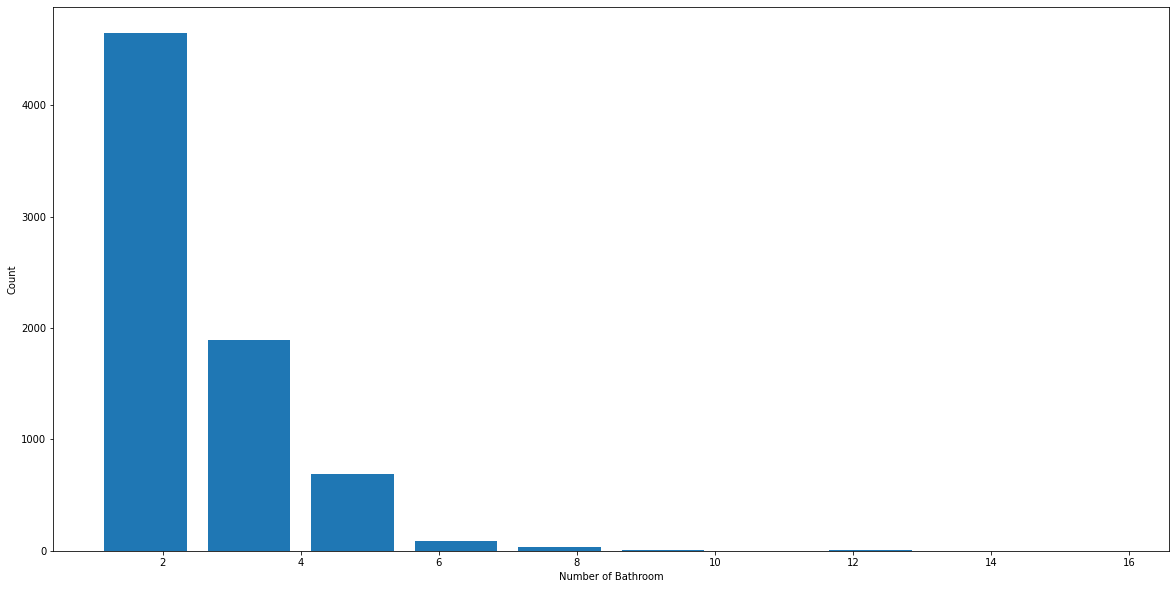

In [40]:
plt.hist(df7.bath, rwidth = 0.8)
plt.xlabel('Number of Bathroom')
plt.ylabel('Count')

In [41]:
df7[df7.bath > df7.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1713,Ajmiriganj,3 BHK,1806.0,6.0,116.0,3,6423.034330
7053,Dumuria,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
8739,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


In [42]:
df8 = df7[df7.bath < df7.bhk+2]
df8.shape

(7300, 7)

In [43]:
df9 = df8.drop(['size', 'price_per_sqft'], axis = 'columns')
df9.head(3)

,location,total_sqft,bath,price,bhk
1,1St Phase Bancharampur,824.0,2.0,60.0,2
2,1St Phase Bancharampur,2145.0,3.0,175.0,3
3,1St Phase Bancharampur,1804.0,3.0,121.0,3
